# Learning and Decision Making

## Laboratory 4: Supervised learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The IRIS dataset

The Iris flower data set is a data set describing the morphologic variation of Iris flowers of three related species. Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".

The data set consists of 50 samples from each of three species of Iris (_Iris setosa_, _Iris virginica_ and _Iris versicolor_). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

In your work, you will use the Iris dataset, considering only two of the three species of Iris.

---

We start by loading the dataset. The Iris dataset is available directly as part of `scikit-learn`and we use the `scikit-learn` command `load_iris` to retrieve the data.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets as data

# Load dataset and print its description
iris = data.load_iris()
print(iris.DESCR)

data_X = iris.data[50:,:]          # Select only 2 classes
data_y = 2 * iris.target[50:] - 3  # Set output to {-1, +1}

# Get dimensions 
nP = data_X.shape[0]
nF = data_X.shape[1]

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In the first activity, you will prepare and visualize the data, before running the learning algorithms.

---

#### Activity 1.        

* Split the data into training and test sets. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to 1/10th of your data. For reproducibility, set `random_state` to some fixed value.

* Plot the training data. In particular, for every pair of features/attributes, create a scatter plot where different classes are plotted with different symbols. You may find useful the `subplot` command from `matplotlib.pyplot`.

* Standardize the training data to have 0-mean and unitary standard deviation. You may find useful the `StandardScaler` from `sklearn.preprocessing`.

**Note 1:** You may want to force the train and test data to a floating point representation, which you can do using the `astype` method of numpy arrays.

**Note 2:** Keep in mind that the test data should not be used for any design or validation decisions.

---

<IPython.core.display.Javascript object>


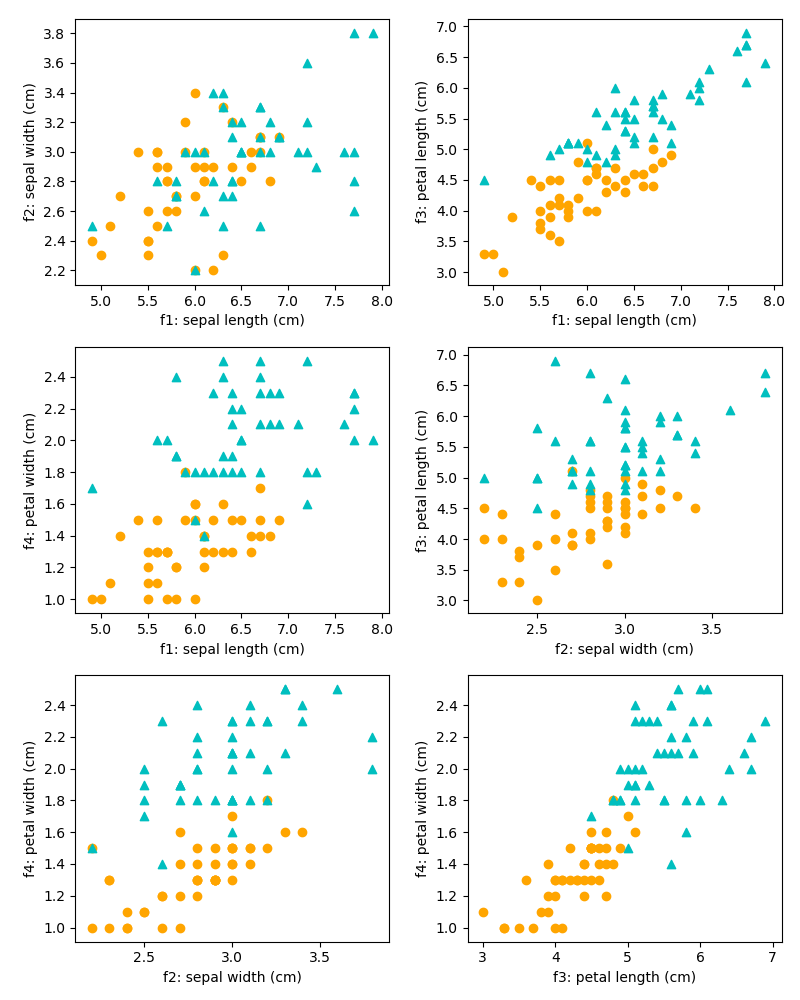

In [2]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

plt.rcParams['figure.figsize'] = [8, 10]

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_y, test_size=.1, random_state=42)

for plot, t in enumerate(itertools.combinations([0,1,2,3], 2)):
    i, j = t

    ax = plt.subplot(3, 2, plot+1)
    ax.scatter(train_X[np.where(train_Y == -1),i], train_X[np.where(train_Y == -1),j], marker='o', color='orange')
    ax.scatter(train_X[np.where(train_Y == 1),i], train_X[np.where(train_Y == 1),j], marker='^', color='c')
    ax.set_xlabel("f" + str(i+1) + ": " + iris.feature_names[i])
    ax.set_ylabel("f" + str(j+1) + ": " + iris.feature_names[j])

scaler = StandardScaler()

scaler.fit(train_X)
train_X = scaler.transform(train_X)
    
plt.tight_layout()

You will now use a very simple linear regression model, similar to the one studied in the homework, to discriminate between the two classes using only two features as inputs. To do so, you will create two artificial features that seek to capture most of the variability in the data using _principal component analysis_.

---

#### Activity 2. 

* Run PCA on the training set to get a representation of the data using only the two principal components. To do this, you should first fit the PCA model to the data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* Use the PCA model fit to the training data to also transform the test data.

---

<IPython.core.display.Javascript object>


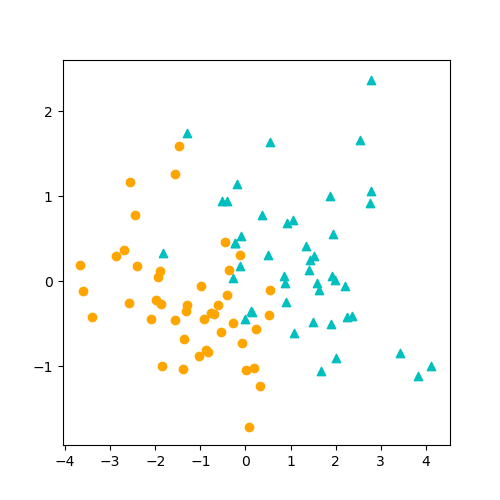

In [3]:
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = [5, 5]

pca = PCA(n_components=2)
pca.fit(train_X)

train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

plt.scatter(train_X[np.where(train_Y == -1),0], train_X[np.where(train_Y == -1),1], marker='o', color='orange')
plt.scatter(train_X[np.where(train_Y == 1),0], train_X[np.where(train_Y == 1),1], marker='^', color='c')

pass


---

#### Activity 3.        

Train a logistic regression classifier in Python using Newton-Raphson's method. The method is described by the update:

$$\mathbf{w}^{(k+1)}\leftarrow\mathbf{w}^{(k)}-\mathbf{H}^{-1}\mathbf{g},$$

where $\mathbf{H}$ and $\mathbf{g}$ are the _Hessian matrix_ and _gradient vector_ that you computed in your homework. Therefore, to train the classifier you should write a cycle that repeatedly updates the parameter vector according to the rule above until the difference between two iterations is sufficiently small (e.g., smaller than $10^{-5}$).

Print the resulting parameters and plot the decision boundary over the data points. Make sure that:

1. You use the data from Activity 2, augmenting it with an extra feature that is always 1
2. You initialize your parameters to zero.

---

<IPython.core.display.Javascript object>


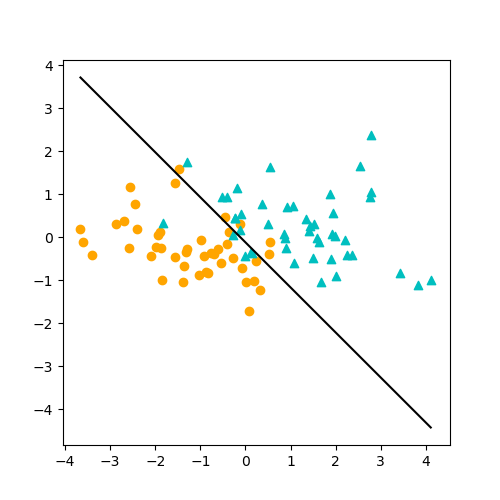

In [86]:
import numpy.linalg

eps = 10e-5
N = len(train_X)

train_X1 = np.append(np.ones((N,1)), train_X, axis=1)

def phi(n):
    return train_X1[n].T


def a(n):
    return train_Y[n]


def pi(n, w):
    return 1 / (1 + np.exp(-a(n) * w.T.dot(phi(n))))


def g(w):
    s = np.zeros((train_X1.shape[1]))
    
    for n in range(N):
        an = a(n)
        xn = phi(n)
        
        s += an * xn * (pi(n, w) - 1)
    
    return (1/N) * s


def H(w):
    s = np.zeros((train_X1.shape[1], train_X1.shape[1]), dtype=float)
    
    for n in range(N):
        s += np.diag(phi(n)).dot(np.diag(phi(n).T)) * pi(n, w) * (1 - pi(n,w))
    
    return (1/N) * s
    

def update(w):
    return w - numpy.linalg.inv(H(w)).dot(g(w))


w = np.array([0,0,0])
while True:
    new_w = update(w)
    if abs(numpy.linalg.norm(w - new_w)) < eps:
        break
    w = new_w

plt.scatter(train_X[np.where(train_Y == -1),0], train_X[np.where(train_Y == -1),1], marker='o', color='orange')
plt.scatter(train_X[np.where(train_Y == 1),0], train_X[np.where(train_Y == 1),1], marker='^', color='c')

X = np.sort(train_X1[:,1])
plt.plot(X, -(w[0] + X * w[1]) / w[2], color='black')

---

#### Activity 4.

You will now compare the classifier from Activity 3 with a logistic regression classifier implemented in `sci-kit learn`. To do so, 

* Fit the logistic regression model to the data from Activity 2. The model can be imported from the `sklearn.linear_model` library under the name `LogisticRegression`. You should use the `newton-cg` solver and a regularization coefficient $C=1e40$.

* Compare the parameter vector and decision region obtained with those from Activity 3. In particular, plot the two decision boundaries over the data points.

* Compute the accuracy of your model on the training and test set. Use the `accuracy_score` function from the `sklearn.metrics` module.

---

In [ ]:
# Insert your code here

In the continuation, you will investigate whether the performance of the model can be improved by augmenting its predictive power. In particular, you will now observe the impact of the parameter $C$ in the logistic regression model.

---

#### Activity 6.

In this activity you will compare the performance of different logistic regression classifiers as you change the parameter $C$. To this purpose,

* Start by further splitting the training dataset from Activity 1 into two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training dataset and $D_V$ to the remaining $15\%$. You will use $D_T$ for training and $D_V$ for validation. 

* For $c\in[1\times10^{-3},10^4]$,

  * Using $D_T$, train a logistic regression model with $C=c$ and using `newton-cg` as the solver.

  * Compute the accuracy both in $D_T$ and in $D_V$;

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 100 times and plot the average accuracy in $D_T$ (training accuracy) and in $D_V$ (test accuracy) across the 100 runs, as a function of $C$. Interpret the observed results, offering an explanation both to the observed classifier behavior and the role of $C$.

** Note: ** The whole process may take a while, so don't despair.

---

In [ ]:
# Insert your code here